In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import time

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
(237, 1000)


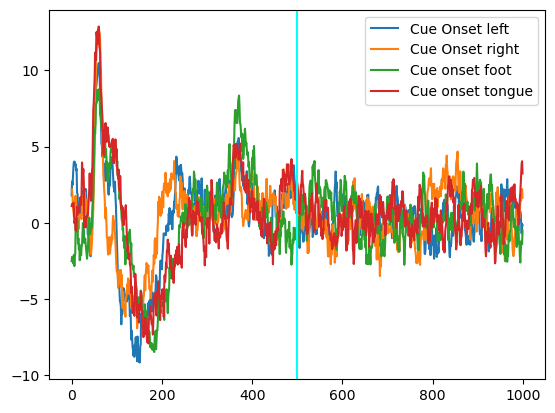

In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

subzero_idx_train = [i for i, x in enumerate(person_train_valid) if x == 0]; subzero_idx_test = [i for i, x in enumerate(person_test) if x == 0] 
subone_idx_train = [i for i, x in enumerate(person_train_valid) if x == 1]; subone_idx_test = [i for i, x in enumerate(person_test) if x == 1] 
subtwo_idx_train = [i for i, x in enumerate(person_train_valid) if x == 2]; subtwo_idx_test = [i for i, x in enumerate(person_test) if x == 2]
subthree_idx_train = [i for i, x in enumerate(person_train_valid) if x == 3];subthree_idx_test = [i for i, x in enumerate(person_test) if x == 3]
subfour_idx_train = [i for i, x in enumerate(person_train_valid) if x == 4];subfour_idx_test = [i for i, x in enumerate(person_test) if x == 4]
subfive_idx_train = [i for i, x in enumerate(person_train_valid) if x == 5];subfive_idx_test = [i for i, x in enumerate(person_test) if x == 5]
subsix_idx_train = [i for i, x in enumerate(person_train_valid) if x == 6]; subsix_idx_test = [i for i, x in enumerate(person_test) if x == 6]
subseven_idx_train = [i for i, x in enumerate(person_train_valid) if x == 7];subseven_idx_test = [i for i, x in enumerate(person_test) if x == 7]
subeight_idx_train = [i for i, x in enumerate(person_train_valid) if x == 8];subeight_idx_test = [i for i, x in enumerate(person_test) if x == 8]
# Factor out the first subject, change this line when train on different subjects
y_train_valid -= 769  # 769 stands for score of class 0 
y_test -= 769

X_train_sub0 = X_train_valid[subzero_idx_train]
y_train_sub0 = y_train_valid[subzero_idx_train]
X_test_sub0 = X_test[subzero_idx_test]
y_test_sub0 = y_test[subzero_idx_test]
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3


## Visualizing the data(for subject i)

#ch_data = X_train_valid[:,8,:]
ch_data = X_train_sub0[:,8,:]
print(ch_data.shape)

# c_0_ind2 = [i for i,x in enumerate(y_train_valid) if x == 0]
# ch_data_class_0 = ch_data[c_0_ind2]

#class_0_ind = np.where(y_train_valid == 0)
class_0_ind  = np.where(y_train_sub0 == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


#class_1_ind = np.where(y_train_valid == 1)
class_1_ind  = np.where(y_train_sub0 == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

#class_2_ind = np.where(y_train_valid == 2)
class_2_ind  = np.where(y_train_sub0 == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

#class_3_ind = np.where(y_train_valid == 3)
class_3_ind  = np.where(y_train_sub0 == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [4]:

## Preprocessing the dataset

X_train_valid_prep = X_train_sub0[:,:,0:500]
X_test_prep_sub0 = X_test_sub0[:,:,0:500]
X_test_tot = X_test[:,:,0:500]
#tot_size = 2115
tot_size = X_train_sub0.shape[0]
## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(tot_size, tot_size//4, replace=False)
ind_train = np.array(list(set(range(tot_size)).difference(set(ind_valid))))
# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_sub0[ind_train], y_train_sub0[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test_sub0 = to_categorical(y_test_sub0, 4)
y_test = to_categorical(y_test, 4)

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test_sub0.shape)
print('Shape of total test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep_sub0.reshape(X_test_prep_sub0.shape[0], X_test_prep_sub0.shape[1], X_test_prep_sub0.shape[2], 1)
X_test_tot = X_test_tot.reshape(X_test_tot.shape[0], X_test_tot.shape[1], X_test_tot.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)
print('Shape of total test set after adding width info:',X_test_tot.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
X_test_tot = np.swapaxes(X_test_tot, 1,3)
X_test_tot = np.swapaxes(X_test_tot, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',X_test.shape)
print('Shape of total test set after dimension reshaping:',X_test_tot.shape)


Shape of training set: (178, 22, 500)
Shape of validation set: (59, 22, 500)
Shape of training labels: (178,)
Shape of validation labels: (59,)
Shape of training labels after categorical conversion: (178, 4)
Shape of validation labels after categorical conversion: (59, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of total test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (178, 22, 500, 1)
Shape of validation set after adding width info: (59, 22, 500, 1)
Shape of test set after adding width info: (50, 22, 500, 1)
Shape of total test set after adding width info: (443, 22, 500, 1)
Shape of training set after dimension reshaping: (178, 500, 1, 22)
Shape of validation set after dimension reshaping: (59, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 22, 1000)
Shape of total test set after dimension reshaping: (443, 500, 1, 22)


In [5]:
 #[conv - batchnorm -relu-pool]xN - [affine]xM - [softmax] 
# Define the shallow CNN model
import tensorflow.keras.backend as K

# Clear the current TensorFlow session
K.clear_session()

drop = 0.7

ShallowCNN = Sequential()
ShallowCNN.add(Conv2D(40, (25, 1), activation='elu', input_shape=(500, 1,22)))
ShallowCNN.add(BatchNormalization())
ShallowCNN.add(Dropout(drop))
ShallowCNN.add(AveragePooling2D(pool_size=(5, 1), padding='same',strides=(5, 1)))

ShallowCNN.add(Conv2D(40, (25, 1), activation='elu'))
ShallowCNN.add(BatchNormalization())
ShallowCNN.add(Dropout(drop))
ShallowCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ShallowCNN.add(Conv2D(25, (3, 1), activation='elu'))
ShallowCNN.add(BatchNormalization())
ShallowCNN.add(Dropout(drop))
ShallowCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ShallowCNN.add(Flatten())
ShallowCNN.add(Dense(100, activation='elu'))
ShallowCNN.add(Dense(4, activation='softmax'))  # Assuming 4 output classes

# Printing the model summary
ShallowCNN.summary()


/Users/haoyuluo/anaconda3/envs/new183/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 476, 1, 40)     │        22,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 476, 1, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 476, 1, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 96, 1, 40)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 1, 40)      │        40,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 1, 40)      │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 1, 40)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 36, 1, 40)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 1, 25)      │         3,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 1, 25)      │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 34, 1, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 17, 1, 25)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 425)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        42,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,529 (423.94 KB)

 Trainable params: 108,319 (423.12 KB)

 Non-trainable params: 210 (840.00 B)

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 500
decay_rate = 0.0001
momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum,weight_decay=decay_rate)
# Specify the GPU device
with tf.device('/GPU:0'):
    # Compiling the model
    ShallowCNN.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    
    # Record training time and accuracy at each epoch
    training_time_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        # Perform training for one epoch
        
        # Print progress
        print(f"Epoch [{epoch}/{epochs}]")
        
        # Training and validating the model for one epoch
        ShallowCNN_results = ShallowCNN.fit(x_train,
                                             y_train,
                                             batch_size=65,
                                             epochs=1,
                                             validation_data=(x_valid, y_valid),
                                             verbose=True)
        # Record training time
        training_time = time.time() - start_time   
        training_time_history.append(training_time)
        train_accuracy_history.append(ShallowCNN_results.history['accuracy'])
        val_accuracy_history.append(ShallowCNN_results.history['val_accuracy'])

Epoch [0/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2743 - loss: 2.2308 - val_accuracy: 0.2881 - val_loss: 4.3126
Epoch [1/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2192 - loss: 2.3457 - val_accuracy: 0.2881 - val_loss: 3.6495
Epoch [2/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2476 - loss: 2.2857 - val_accuracy: 0.2881 - val_loss: 3.1230
Epoch [3/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2912 - loss: 1.9308 - val_accuracy: 0.2881 - val_loss: 2.7590
Epoch [4/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3038 - loss: 1.8820 - val_accuracy: 0.3051 - val_loss: 2.4010
Epoch [5/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3215 - loss: 1.9887 - val_accuracy: 0.3390 - val_loss: 2.1396
Epoch [6/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3151 - loss: 1.9769 - val_accuracy: 0.3220 - val_loss: 1.9924
Epoch [7/500]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3484 - loss: 1.6938 - val_accuracy: 0.

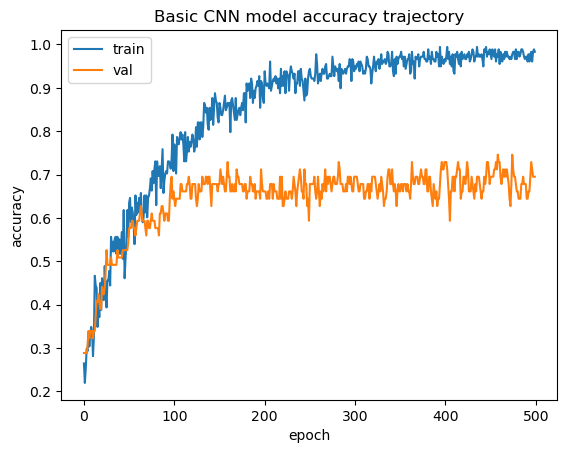

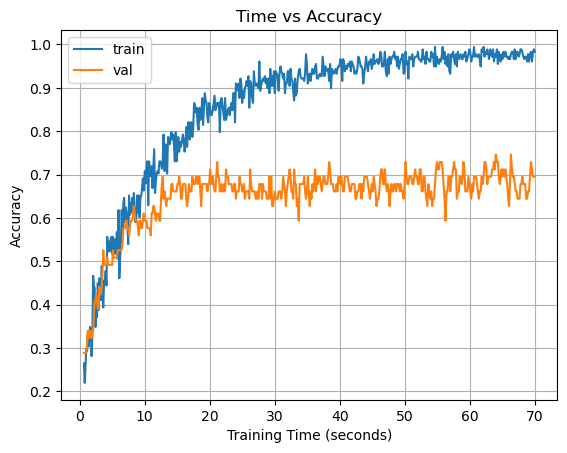

In [7]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# # Plotting loss trajectory
# plt.plot(ShallowCNN_results.history['loss'],'o')
# plt.plot(ShallowCNN_results.history['val_loss'],'o')
# plt.title('Basic CNN model loss trajectory')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# Plot time vs accuracy
plt.plot(training_time_history, train_accuracy_history)
plt.plot(training_time_history, val_accuracy_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Time vs Accuracy')
plt.grid(True)
plt.show()

In [8]:
## Testing the CNN model
print(x_test.shape)
print(X_test_tot.shape)
cnn_score_sub0 = ShallowCNN.evaluate(x_test, y_test_sub0, verbose=0)
cnn_score_all = ShallowCNN.evaluate(X_test_tot, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score_sub0[1])
print('Test accuracy of the basic CNN model on all subjects:',cnn_score_all[1])
#print('Test accuracy of the basic CNN model on all subjects:',cnn_score_all[1])

(50, 500, 1, 22)
(443, 500, 1, 22)
Test accuracy of the basic CNN model: 0.6399999856948853
Test accuracy of the basic CNN model on all subjects: 0.43340858817100525


## Discussion on Effect of optimizing subject 1.

-As we can see from the training result, the optimized testing accuracy for subject one is smaller than the overall testing accuracy. This could happen since the training data size is smaller(only about size 200), and so does the testing data size(50). So, the model may be more biased and easily affected by the selection of training and testing samples(less stable than a large sample-size model).

-It's certain that it's not helpful for training across all subjects. The reasons are training sample for subject 1 is more biased for that specific person. Using that to generalize the characteristic of channel activities across all other samples may produce very large error. For example, the 22 channels' data in one person might correspond to an action of foot while a very similar data group maps to tounge activity to another person.



In [138]:
 #[conv - batchnorm -relu-pool]xN - [affine]xM - [softmax] 
# Define the shallow CNN model
import tensorflow.keras.backend as K

# Clear the current TensorFlow session
K.clear_session()

drop = 0.3

ComplexCNN = Sequential()
ComplexCNN.add(Conv2D(40, (3, 1), activation='elu', input_shape=(500, 1,22)))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Conv2D(40, (3, 1), activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))
ComplexCNN.add(AveragePooling2D(pool_size=(2, 1), padding='same',strides=(2, 1)))

ComplexCNN.add(Flatten())

ComplexCNN.add(Dense(100, activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))

ComplexCNN.add(Dense(100, activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))

ComplexCNN.add(Dense(400, activation='elu'))
ComplexCNN.add(BatchNormalization())
ComplexCNN.add(Dropout(drop))

ComplexCNN.add(Dense(4, activation='softmax'))  # Assuming 4 output classes

# Printing the model summary
ComplexCNN.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 1, 40)        2680      
                                                                 
 batch_normalization (Batch  (None, 498, 1, 40)        160       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 498, 1, 40)        0         
                                                                 
 average_pooling2d (Average  (None, 249, 1, 40)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 1, 40)        4840      
                                                                 
 batch_normalization_1 (Bat  (None, 247, 1, 40)        1

In [139]:
learning_rate = 1e-3
epochs = 400
decay_rate = 0.0005
momentum = 0.9
optimizer = Adam(learning_rate=learning_rate, weight_decay=decay_rate,use_ema=True,ema_momentum=momentum)
# Specify the GPU device
with tf.device('/GPU:1'):
    # Compiling the model
    ComplexCNN.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    
    # Record training time and accuracy at each epoch
    training_time_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        # Perform training for one epoch
        
        # Print progress
        print(f"Epoch [{epoch}/{epochs}]")
        
        # Training and validating the model for one epoch
        ComplexCNN_results = ComplexCNN.fit(x_train,
                                             y_train,
                                             batch_size=64,
                                             epochs=1,
                                             validation_data=(x_valid, y_valid),
                                             verbose=True)
        # Record training time
        training_time = time.time() - start_time   
        training_time_history.append(training_time)
        train_accuracy_history.append(ComplexCNN_results.history['accuracy'])
        val_accuracy_history.append(ComplexCNN_results.history['val_accuracy'])

Epoch [0/400]
26/26 [==============================] - 9s 109ms/step - loss: 1.8563 - accuracy: 0.2793 - val_loss: 1.4209 - val_accuracy: 0.2960
Epoch [1/400]
26/26 [==============================] - 2s 93ms/step - loss: 1.6138 - accuracy: 0.3443 - val_loss: 1.3802 - val_accuracy: 0.3380
Epoch [2/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.5951 - accuracy: 0.3406 - val_loss: 1.3097 - val_accuracy: 0.3860
Epoch [3/400]
26/26 [==============================] - 2s 93ms/step - loss: 1.5246 - accuracy: 0.3659 - val_loss: 1.2931 - val_accuracy: 0.4080
Epoch [4/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.4832 - accuracy: 0.3827 - val_loss: 1.2743 - val_accuracy: 0.4600
Epoch [5/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.3885 - accuracy: 0.4409 - val_loss: 1.3596 - val_accuracy: 0.4520
Epoch [6/400]
26/26 [==============================] - 2s 91ms/step - loss: 1.3595 - accuracy: 0.4303 - val_loss: 1.2455 - val_accuracy

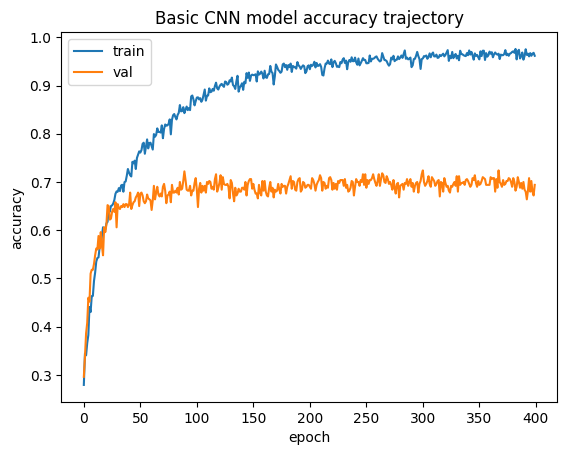

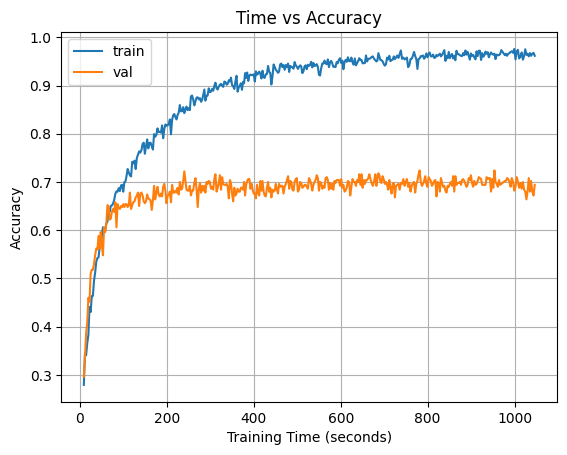

In [140]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# # Plotting loss trajectory
# plt.plot(ShallowCNN_results.history['loss'],'o')
# plt.plot(ShallowCNN_results.history['val_loss'],'o')
# plt.title('Basic CNN model loss trajectory')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# Plot time vs accuracy
plt.plot(training_time_history, train_accuracy_history)
plt.plot(training_time_history, val_accuracy_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Time vs Accuracy')
plt.grid(True)
plt.show()

In [141]:
## Testing the CNN model

cnn_score = ComplexCNN.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6772009134292603
